In [1]:
import numpy as np
from typing import Union

from qiskit import Aer,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance

from squlearn.feature_map import FeatureMapBase,PrunedFeatureMap,pruning_from_QFI,automated_pruning
from squlearn.util.quantum_fisher import get_quantum_fisher

In [2]:
# Example uses statevector as backend
backend = Aer.get_backend('statevector_simulator')
QI = QuantumInstance(backend)

# Nicer numpy output
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [3]:
# Create a simple example pqc with redundant parameters
class example_pqc(FeatureMapBase):

    def __init__(self,number_of_qubits : int):
        # No features / input data in this case
        number_of_features = 0
        super().__init__(number_of_qubits,number_of_features) # Parent initialization

    @ property
    def num_parameters(self) -> int:
        """ Returns the number of trainable parameters of the feature map. """
        return 4*self.num_qubits

    def get_circuit(self,
                    features: Union[ParameterVector,np.ndarray],
                    parameters: Union[ParameterVector,np.ndarray]
                    ) -> QuantumCircuit:

        nparam = len(parameters)

        QC = QuantumCircuit(self.num_qubits)

        ioff = 0
        for i in range(self.num_qubits):
            QC.rz(parameters[ioff % nparam],i)
            ioff = ioff + 1
        for i in range(self.num_qubits):
            QC.ry(parameters[ioff % nparam],i)
            ioff = ioff + 1
        for i in range(self.num_qubits):
            QC.z(i)
        for i in range(self.num_qubits):
            QC.ry(parameters[ioff % nparam],i)
            ioff = ioff + 1
        for i in range(self.num_qubits):
            QC.rz(parameters[ioff % nparam],i)
            ioff = ioff + 1

        return QC

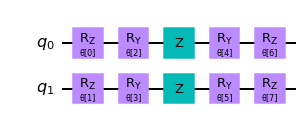

In [4]:
#Example for two qubits
nqubit = 2

# Generate and print the example pqc
pqc = example_pqc(nqubit)
pqc.draw()

In [5]:
# Generate random parameters
np.random.seed(0)
param = np.random.rand(pqc.num_parameters)

# Evaluate and print the Quantum Fisher Information Matrix
QFIM = get_quantum_fisher(pqc, [], param, QI)
print(QFIM)

[[-0.    -0.    -0.     0.     0.     0.    -0.    -0.   ]
 [-0.    -0.     0.     0.     0.     0.    -0.    -0.   ]
 [-0.     0.     1.     0.    -1.    -0.     0.     0.   ]
 [ 0.     0.     0.     1.     0.    -1.     0.    -0.   ]
 [ 0.     0.    -1.     0.     1.    -0.     0.     0.   ]
 [ 0.     0.    -0.    -1.    -0.     1.    -0.     0.   ]
 [-0.    -0.     0.     0.     0.    -0.     0.032  0.   ]
 [-0.    -0.     0.    -0.     0.     0.     0.     0.01 ]]


In [6]:
# Calculate and print the spectrum of the Quantum Fisher Information Matrix
V,D = np.linalg.eig(QFIM)
print(np.sort(V))

[-0.    -0.    -0.     0.     0.01   0.032  2.     2.   ]


In [7]:
# Call the pruning routine and print the pruned parameters
red_gate = pruning_from_QFI(QFIM)
print(np.sort(red_gate))

[0 1 2 5]


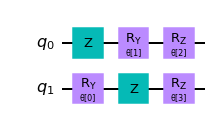

In [8]:
# Construct and print the pruned PQC
pruned_pqc = PrunedFeatureMap(pqc,red_gate)
pruned_pqc.draw()

Pruned parameters: [0 1 3 4]


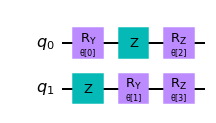

In [9]:
# Example for the automated pruning routine
pruned_pqc_auto = automated_pruning(pqc,QI)
pruned_pqc_auto.draw()